In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
env = gym.envs.make("MountainCar-v0")

[2017-02-20 18:51:23,816] Making new env: MountainCar-v0


In [3]:
env.observation_space # 방향이랑 속도? 의 무한대의 집합

Box(2,)

In [4]:
env.action_space.n

3

* FeatureUnion : Concatenates results of multiple transformer objects.
* RBFSampler : Approximates feature map of an RBF kernel by Monte Carlo approximation of its Fourier transform.

In [5]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples) # (0,sigma^2)로 정규화시키는 전처리..!

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)), # 다른 감마를 사용하여 100차원씩의 특징을 뽑아온다
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [6]:
observation_examples.shape

(10000, 2)

In [7]:
featurizer.transform(scaler.transform(observation_examples)).shape

(10000, 400)

In [8]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            
            # stochastic gradient descent를 위한 모델 셋팅 
            # action의 수만큼 model 준비? value function을 위해..
            model.partial_fit([self.featurize_state(env.reset())], [0]) # 400차원의 instance를 넣으면 scalar 값 나와 error 계산하도록...
            # X : 400차원의 feature, y : scalar(action-state value) 인 regressor
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        정규화시킨 후, 2->400차원으로 매핑 커널
        """
        
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled) 
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            만약 action a가 주어진다면 하나의 숫자로서의 action-value q(s,a) 를 리턴
            만약 action이 안주어진다면, 모든 action에 대한 v(s) 를 벡터로 리턴

            
        """
        features = self.featurize_state(s)
        if not a: 
            return np.array([m.predict([features])[0] for m in self.models])
        else:
            return self.models[a].predict([features])[0]
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [y])

In [9]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [10]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # behaviour policy (e-greedy) 생성 with epsilon_decay
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # SARSA 일때 사용, not q-learning
        next_action = None # ?
        
        # One step in the environment
        for t in itertools.count():
                        
            # q=learning일 때,
            if next_action is None:
                action_probs = policy(state) # behaviour policy에서 action_probs을 얻어와서
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs) # e-greedy를 따라 action 취한다.
            else:
                action = next_action
            
            # 한 스텝 가본다
            next_state, reward, done, _ = env.step(action)
    
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # q-value를 estimator로 approximation 해본다
            q_values_next = estimator.predict(next_state)
            
            # Use this code for Q-Learning
            # Q-Value TD Target
            td_target = reward + discount_factor * np.max(q_values_next) # TD-target , greedy로 액션 선택
            
            # Use this code for SARSA TD Target for on policy-training:
            # next_action_probs = policy(next_state)
            # next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)             
            # td_target = reward + discount_factor * q_values_next[next_action]
            
            # target을 위한 approximator를 업데이트한다!
            estimator.update(state, action, td_target)
            
            print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward), end="")
                
            if done:
                break
                
            state = next_state
    
    return stats

In [11]:
estimator = Estimator()

In [12]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
stats = q_learning(env, estimator, 100, epsilon=0.0)

Step 150 @ Episode 100/100 (-145.0)

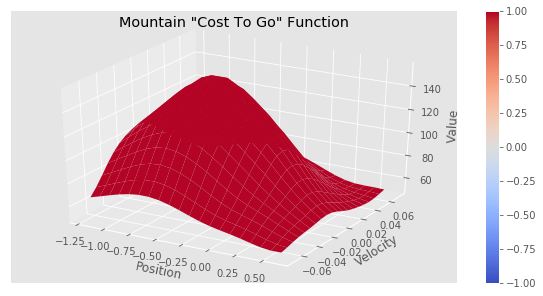

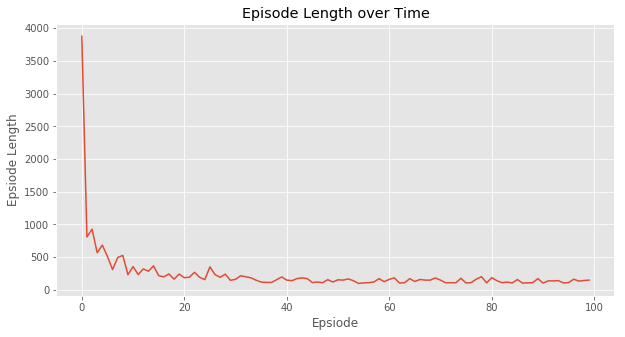

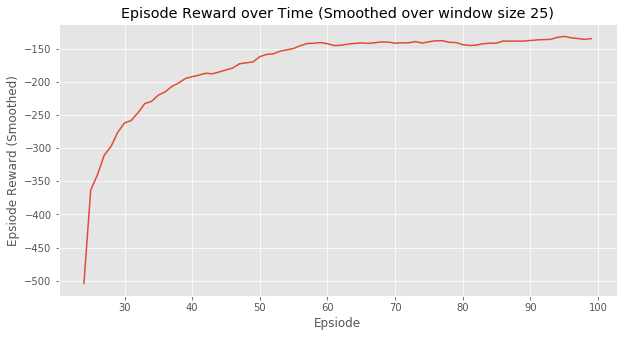

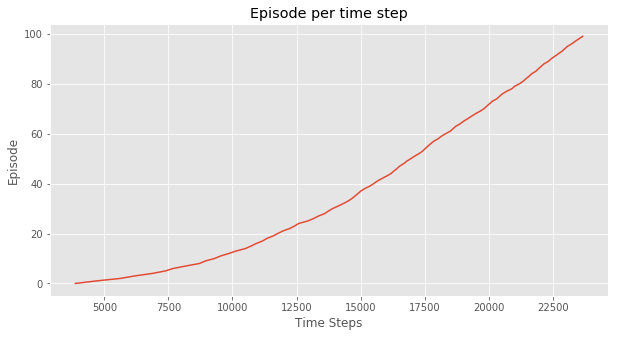

(<matplotlib.figure.Figure at 0x7fd0084abcf8>,
 <matplotlib.figure.Figure at 0x7fd008250ba8>)

In [13]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)

In [14]:
state = env.reset()
for _ in range(10000):
    env.render()
    q_values_next = estimator.predict(state)
    action = np.argmax(q_values_next)
    next_state, reward, done, _ = env.step(action)
    
    if done:
        break
    state = next_state